In [1]:
!nvidia-smi

Sat Nov 29 15:27:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.3/112.6 GB disk)


In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="A68my1cxAVNMrbYlI6rm")
project = rf.workspace("agriculturerobotweeddetection").project("weed_detection-pt34y")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Weed_Detection-1 in yolov8:: 100%|██████████| 5153/5153 [00:00<00:00, 8064.96it/s]


In [5]:
import os
from ultralytics import YOLO

# Step 1: Find the 'data.yaml' file automatically
yaml_path = ""
for root, dirs, files in os.walk("/content"):
    if "data.yaml" in files:
        yaml_path = os.path.join(root, "data.yaml")
        print(f"✅ Success! Found dataset at: {yaml_path}")
        break

if yaml_path == "":
    print("❌ Error: Could not find data.yaml. Please check if Cell 3 finished correctly.")
else:
    # Step 2: Start the Training
    print("🚀 Starting Training... (This will take 30-45 mins)")
    model = YOLO('yolov8s.pt')
    model.train(data=yaml_path, epochs=50, imgsz=640, plots=True)

✅ Success! Found dataset at: /content/Weed_Detection-1/data.yaml
🚀 Starting Training... (This will take 30-45 mins)
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Weed_Detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, 

🔎 Here are the model's predictions (Red/Pink boxes are detections):


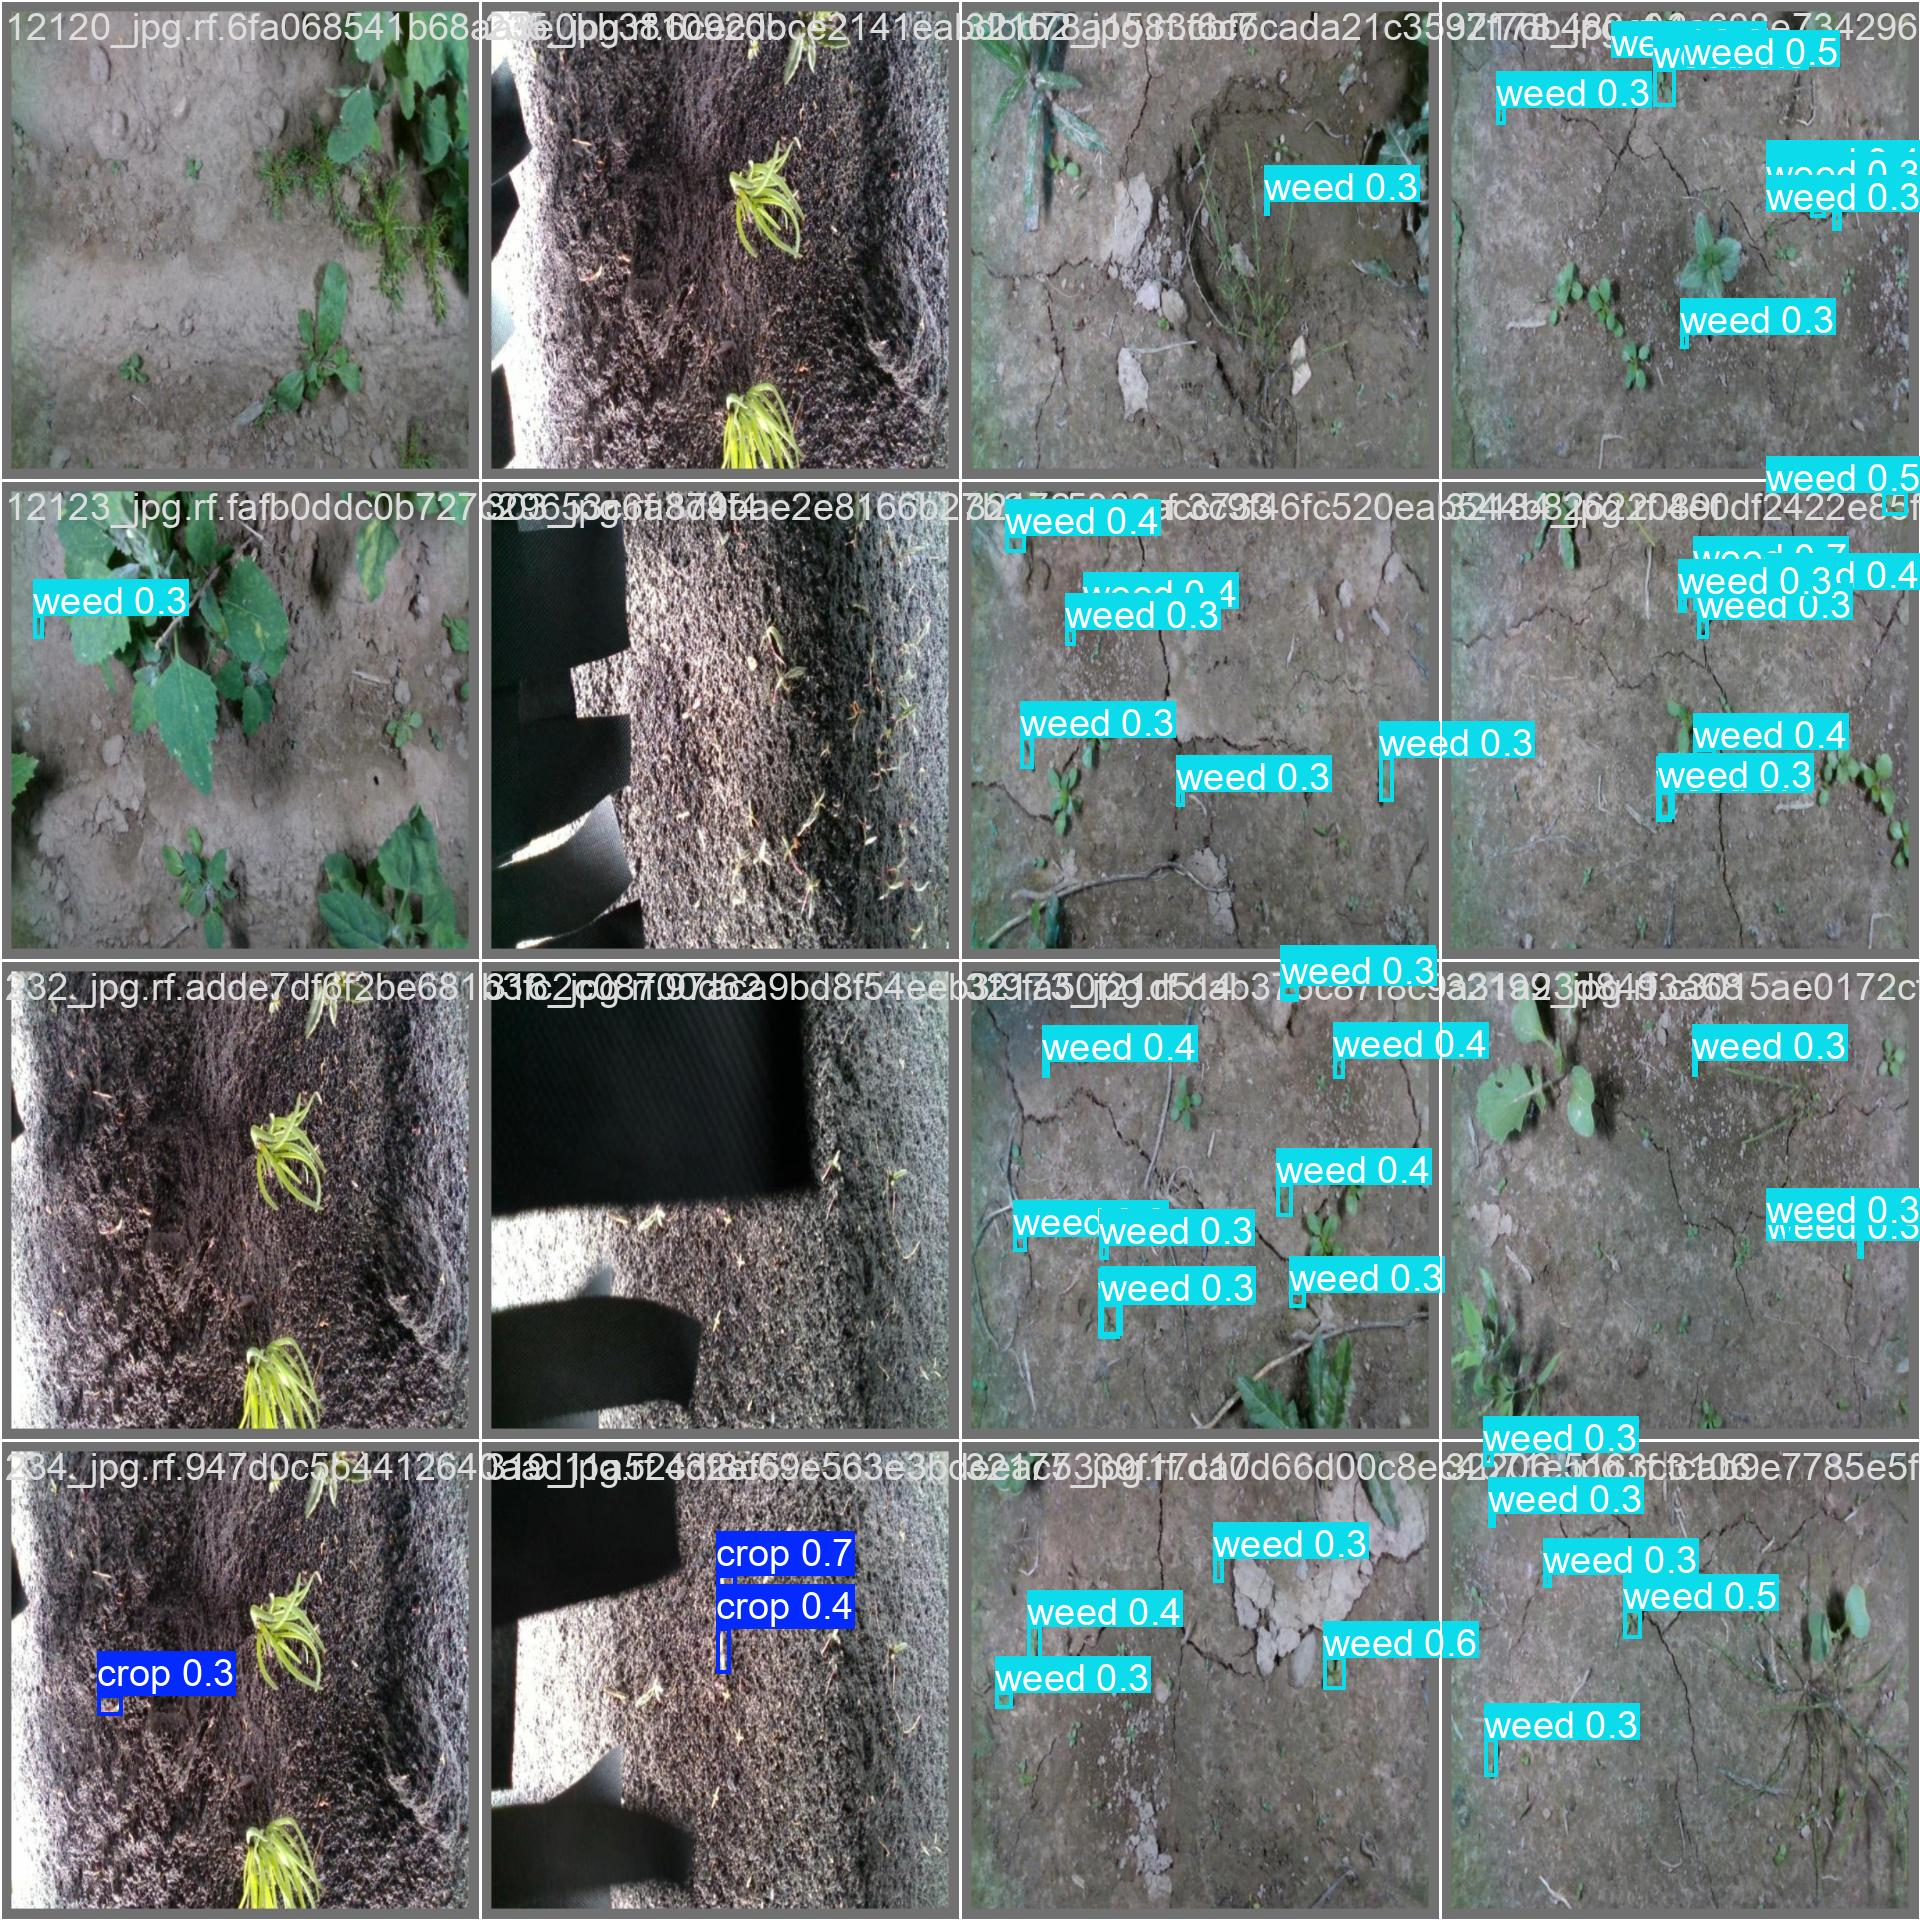

In [6]:
from IPython.display import Image, display

# This shows the image where the model drew boxes around weeds/crops
print("🔎 Here are the model's predictions (Red/Pink boxes are detections):")
display(Image(filename='/content/runs/detect/train/val_batch0_pred.jpg', width=800))

In [7]:
from google.colab import files
files.download('/content/runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📸 Upload an image to test the robot...


Saving test_image.jpg to test_image.jpg

image 1/1 /content/test_image.jpg: 384x640 3 weeds, 45.1ms
Speed: 2.0ms preprocess, 45.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predict

🤖 Robot Vision:


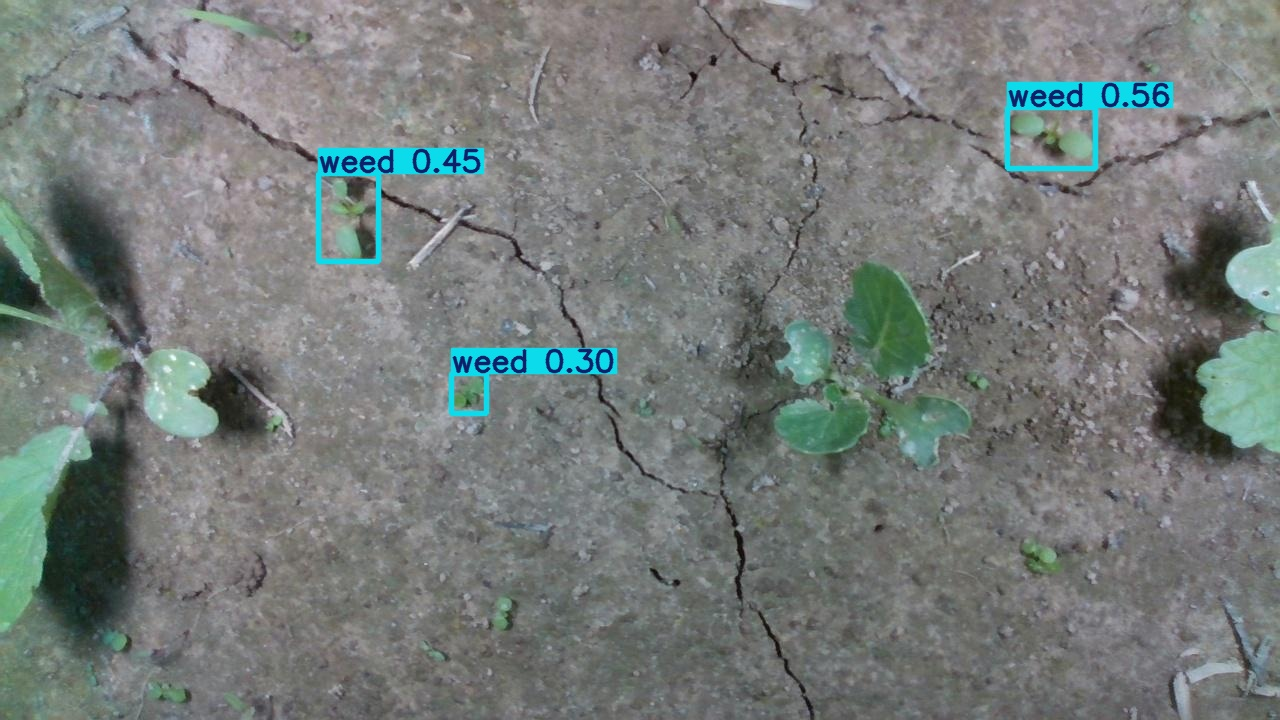

In [8]:
import cv2
from google.colab import files
from IPython.display import Image, display

# 1. Upload a new image
print("📸 Upload an image to test the robot...")
uploaded = files.upload()
filename = next(iter(uploaded))

# 2. Run the detection (The Robot looks at the image)
results = model.predict(source=filename, save=True, conf=0.25)

# 3. Show the result
print("\n🤖 Robot Vision:")
# We find the latest prediction folder automatically
import glob
latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
display(Image(filename=f"{latest_folder}/{filename}", width=600))

In [11]:
# 1. Install the Voice Tool first (Fixes the error)
!pip install gTTS

from gtts import gTTS
from IPython.display import Audio, display

# ==========================================
# 🎛️ CONTROL PANEL (USER SETTINGS)
# ==========================================
ANNOUNCE_WEED_DETECTED = False   # Set to True if you want to hear "Weed Found"
ANNOUNCE_PATH_CLEAR    = True    # Set to True to hear "Path Clear"
# ==========================================

# 2. Analyze what the robot sees
weed_detected = False
detected_name = ""

# Check if results exist and have boxes
if len(results) > 0 and len(results[0].boxes) > 0:
    # Check if the class is actually 'weed'
    class_id = int(results[0].boxes.cls[0])
    detected_name = results[0].names[class_id]

    if detected_name.lower() == "weed":
        weed_detected = True

# 3. Decide whether to speak based on YOUR settings
message = ""

if weed_detected:
    # We found a weed. Do we speak?
    if ANNOUNCE_WEED_DETECTED:
        message = "Warning. Weed Detected."
        print(f"🔴 Visual: {detected_name} found. (Audio: ON)")
    else:
        print(f"🔴 Visual: {detected_name} found. (Audio: OFF - Silent Mode)")

else:
    # No weed found (Path Clear). Do we speak?
    if ANNOUNCE_PATH_CLEAR:
        message = "Path Clear. No weeds."
        print("🟢 Visual: Clear. (Audio: ON)")
    else:
        print("🟢 Visual: Clear. (Audio: OFF)")

# 4. Execute Voice (Only if there is a message)
if message != "":
    tts = gTTS(message)
    tts.save('status_update.wav')
    display(Audio('status_update.wav', autoplay=True))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1
🔴 Visual: weed found. (Audio: OFF - Silent Mode)


In [12]:
from gtts import gTTS
from IPython.display import Audio, display

# ==========================================
# 🎛️ CONTROL PANEL (THE SWITCH)
# ==========================================
ANNOUNCE_WEED_DETECTED = True    # <--- I have switched this ON for you
ANNOUNCE_PATH_CLEAR    = True
# ==========================================

# 1. Analyze what the robot sees
weed_detected = False
detected_name = ""

# Check results
if len(results) > 0 and len(results[0].boxes) > 0:
    class_id = int(results[0].boxes.cls[0])
    detected_name = results[0].names[class_id]

    if detected_name.lower() == "weed":
        weed_detected = True

# 2. Logic: To Speak or Not to Speak?
message = ""

if weed_detected:
    # We found a weed.
    if ANNOUNCE_WEED_DETECTED:
        # SWITCH IS ON -> Prepare Audio
        message = "Warning. Weed Detected."
        print(f"🔴 Visual: {detected_name} found. (Audio: ON - Announcing...)")
    else:
        # SWITCH IS OFF -> Stay Silent
        print(f"🔴 Visual: {detected_name} found. (Audio: OFF - Silent Mode)")

else:
    # Path is clear
    if ANNOUNCE_PATH_CLEAR:
        message = "Path Clear. No weeds."
        print("🟢 Visual: Clear. (Audio: ON)")
    else:
        print("🟢 Visual: Clear. (Audio: OFF)")

# 3. Execute Voice
if message != "":
    tts = gTTS(message)
    tts.save('status_update.wav')
    # This plays the sound
    display(Audio('status_update.wav', autoplay=True))

🔴 Visual: weed found. (Audio: ON - Announcing...)


In [13]:
import cv2
import os
from google.colab import files
from ultralytics import YOLO

# 1. Upload your video
print("🎥 Please upload your 'test_video.mp4' now...")
uploaded = files.upload()
video_filename = next(iter(uploaded))

# 2. Load the model (Double check we have the best one)
# We use the model you just trained
model = YOLO('/content/runs/detect/train/weights/best.pt')

# 3. Run the Robot Vision on the video
print(f"⚙️ Processing {video_filename}... (This might take a minute)")
# save=True draws the boxes on the video
results = model.predict(source=video_filename, save=True, conf=0.25)

print("✅ Processing Complete!")

🎥 Please upload your 'test_video.mp4' now...


Saving test_video.mp4 to test_video.mp4
⚙️ Processing test_video.mp4... (This might take a minute)

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/900) /content/test_video.mp4: 384x640 (no detections), 11.4ms
video 1/1 (frame 2/900) /content/test_video.mp4: 384x640 (no detections), 10.7ms
video 1/1 (frame 3/900) /content/test_video.mp4: 384x640 (no detections), 10.9ms
video 1/1 (frame 4/900) /content/test_video.mp4: 384x640 (no detections), 10.8ms
video 1/1 (frame 5/900) /content/

In [14]:
import glob
from google.colab import files

# 1. Find the latest prediction folder (where the video was saved)
# It usually saves as .avi or .mp4 depending on settings
latest_run = max(glob.glob('/content/runs/detect/predict*'), key=os.path.getmtime)

# 2. Find the video file inside that folder
# We look for any video file inside the latest run folder
video_files = glob.glob(f"{latest_run}/*.mp4") + glob.glob(f"{latest_run}/*.avi")

if len(video_files) > 0:
    processed_video = video_files[0]
    print(f"📥 Downloading your processed video: {processed_video}")
    files.download(processed_video)
else:
    print("❌ Error: Could not find the processed video. Please check if Step 1 finished.")

📥 Downloading your processed video: /content/runs/detect/predict2/test_video.avi


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 THE TRUTH TABLE (Confusion Matrix):
Diagonal line (top-left to bottom-right) = CORRECT guesses.
Squares outside the diagonal = MISTAKES.


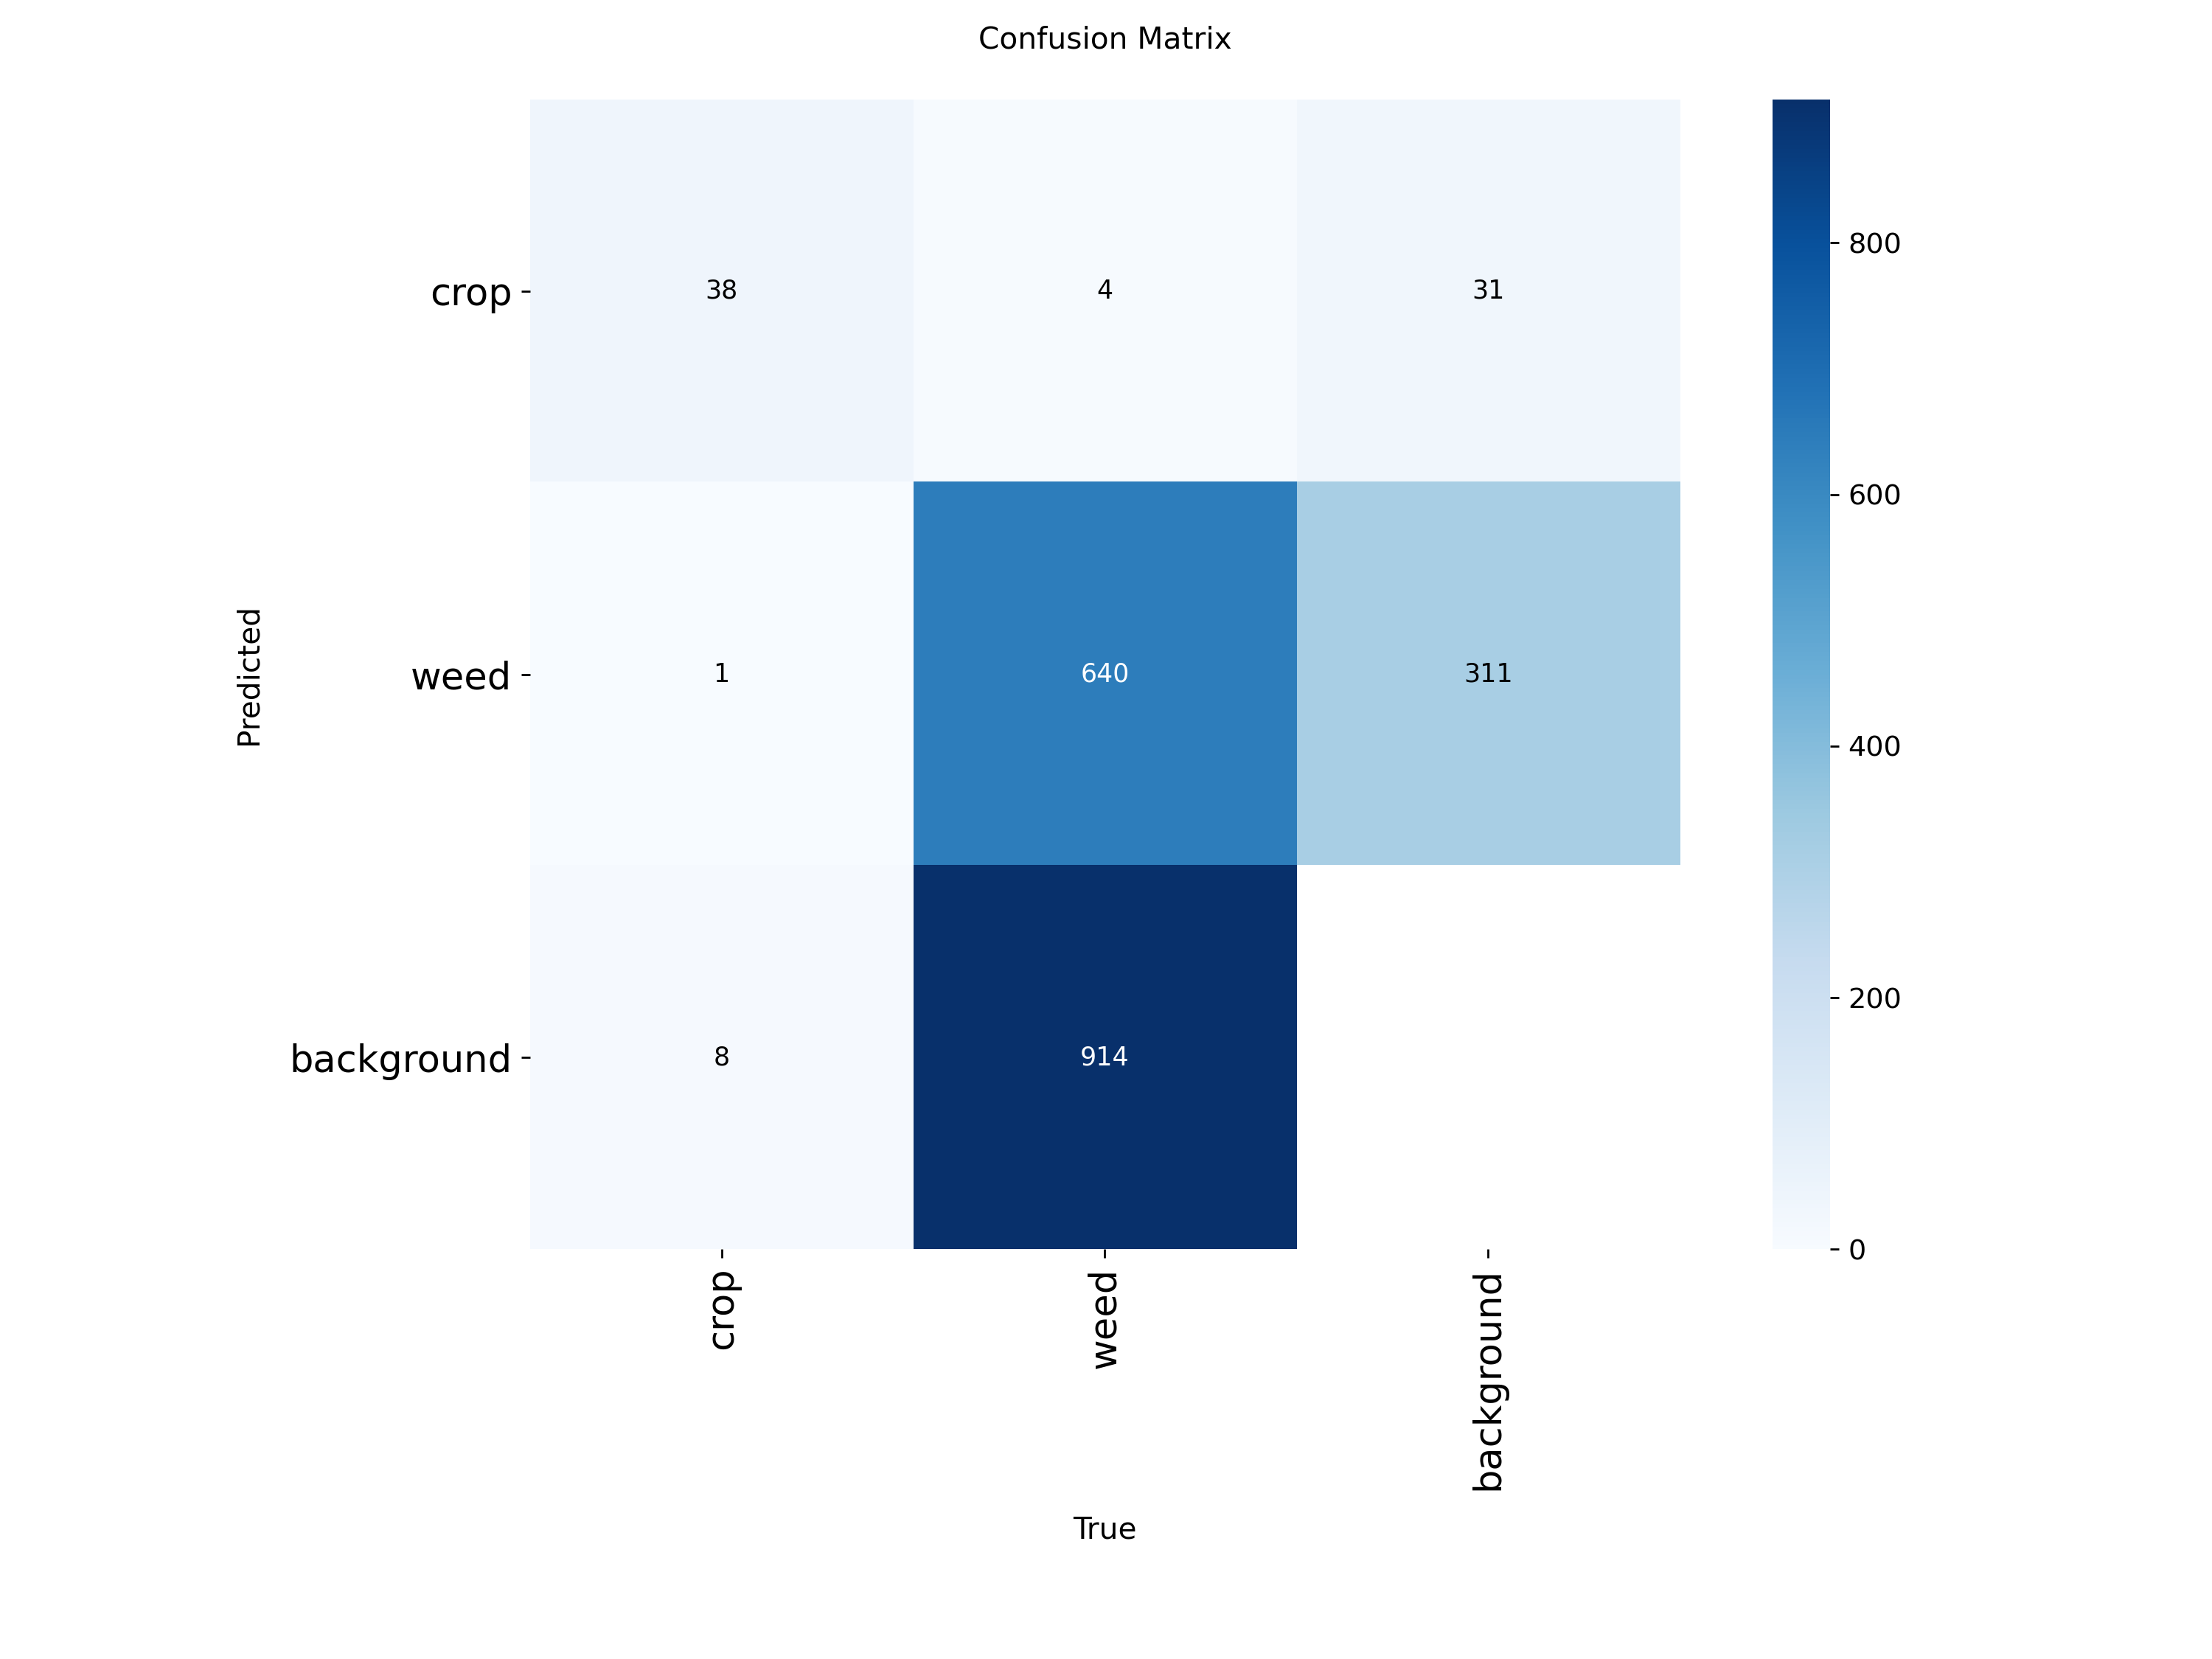

In [15]:
from IPython.display import Image, display
import os

# Find the training folder
latest_train = max([os.path.join('/content/runs/detect', d) for d in os.listdir('/content/runs/detect') if 'train' in d], key=os.path.getmtime)

# 1. Show the Confusion Matrix
conf_matrix_path = os.path.join(latest_train, 'confusion_matrix.png')
print("📊 THE TRUTH TABLE (Confusion Matrix):")
print("Diagonal line (top-left to bottom-right) = CORRECT guesses.")
print("Squares outside the diagonal = MISTAKES.")
display(Image(filename=conf_matrix_path, width=800))

📈 LEARNING CURVE:
• Box Loss (Top Left): Should go DOWN (Errors decreasing).
• mAP50 (Bottom Left): Should go UP (Accuracy increasing).


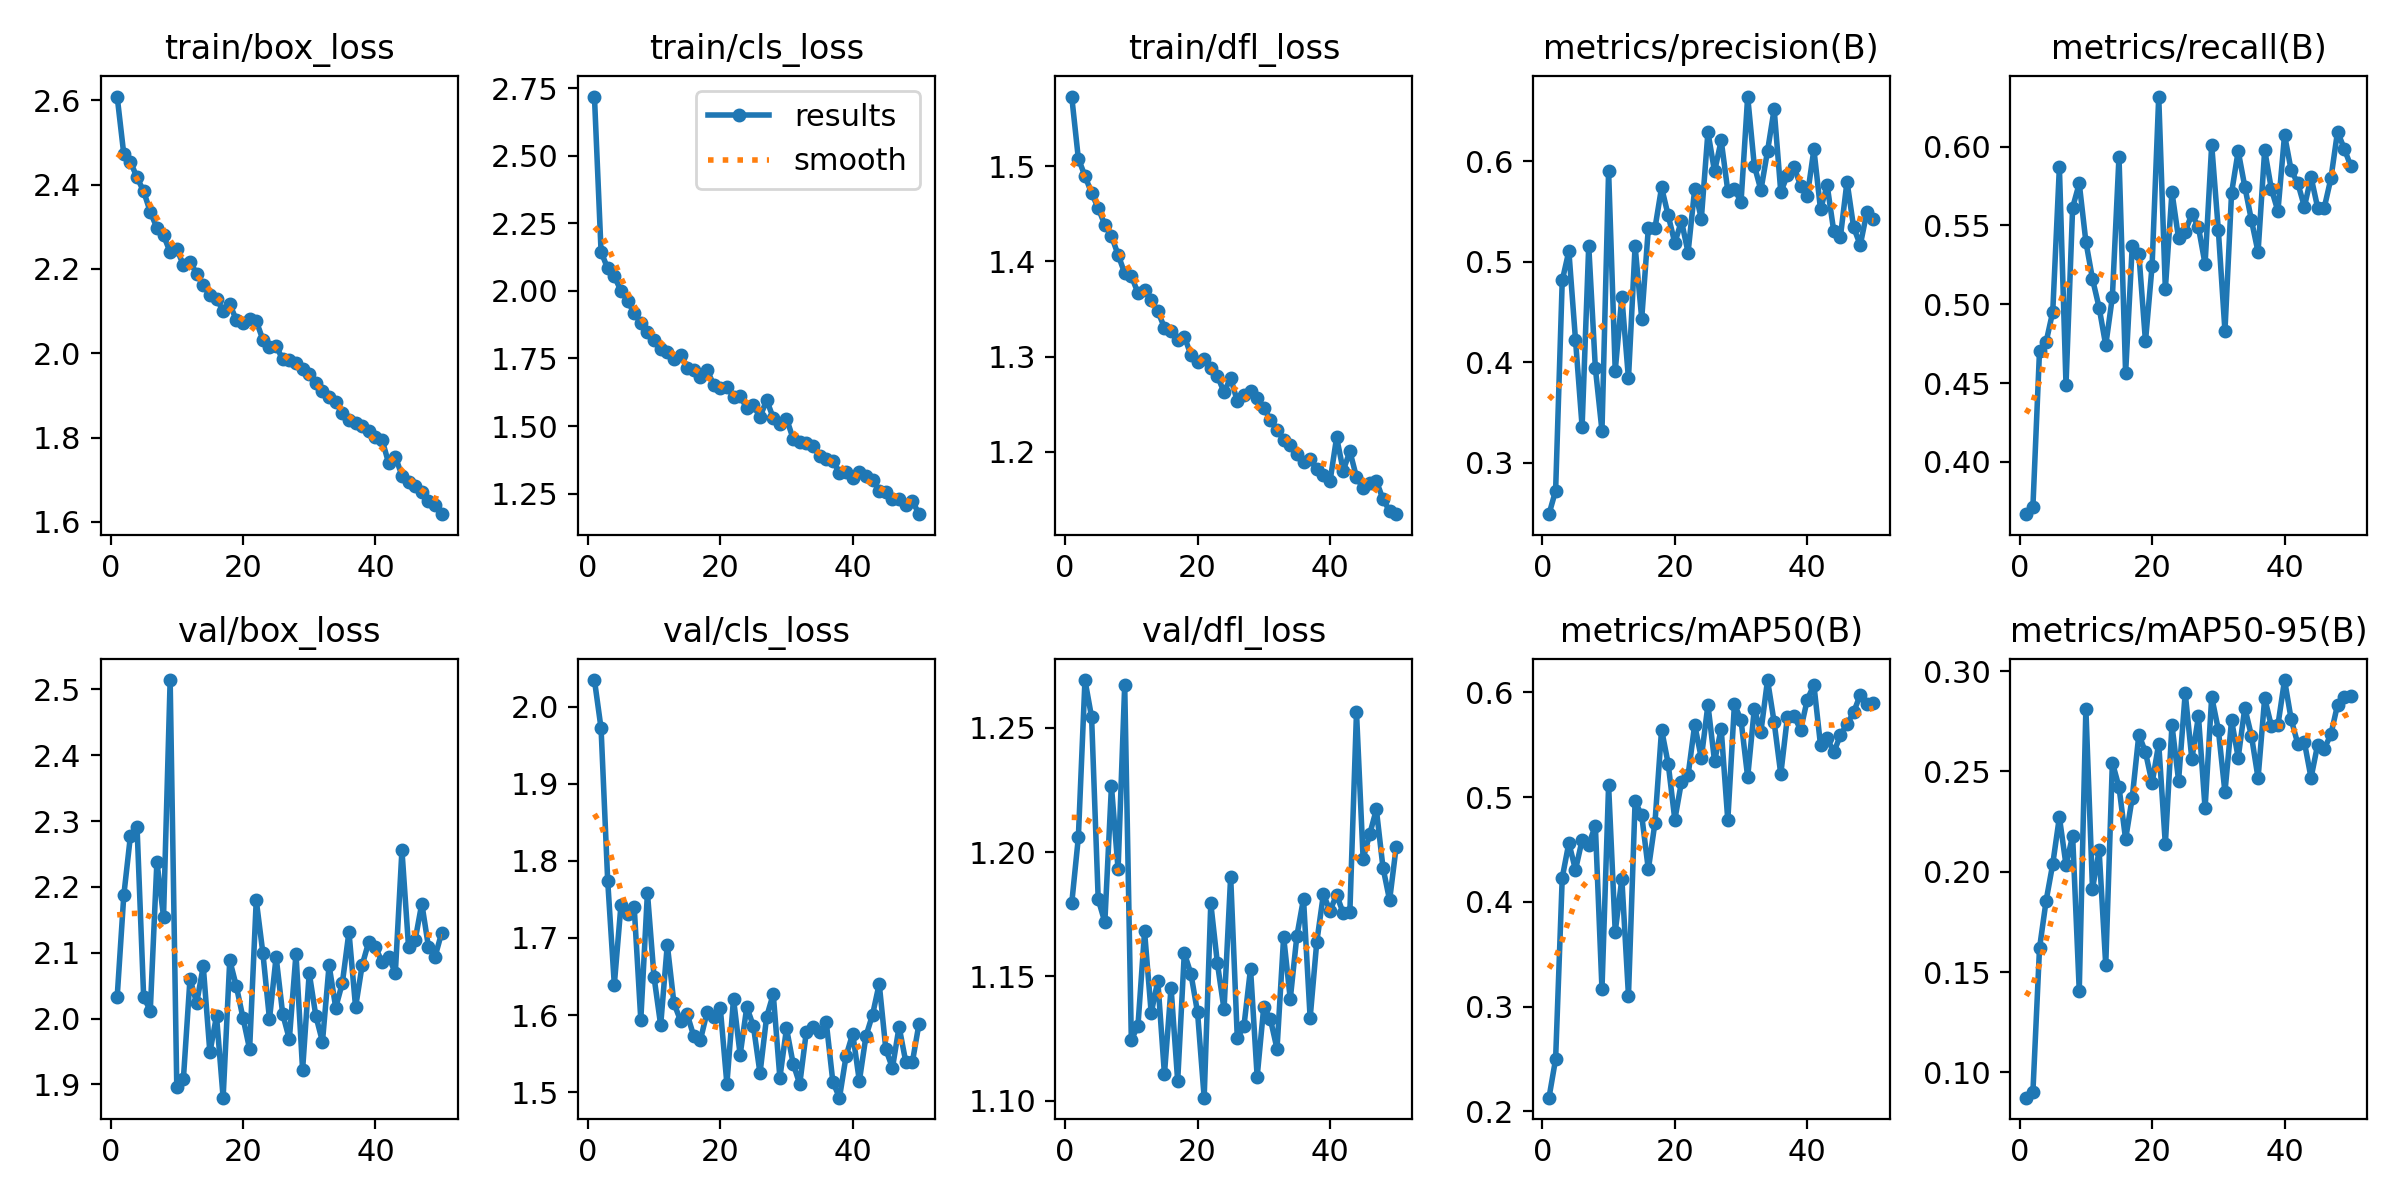

In [18]:
# 2. Show the Training Results
results_path = os.path.join(latest_train, 'results.png')
print("📈 LEARNING CURVE:")
print("• Box Loss (Top Left): Should go DOWN (Errors decreasing).")
print("• mAP50 (Bottom Left): Should go UP (Accuracy increasing).")
display(Image(filename=results_path, width=800))

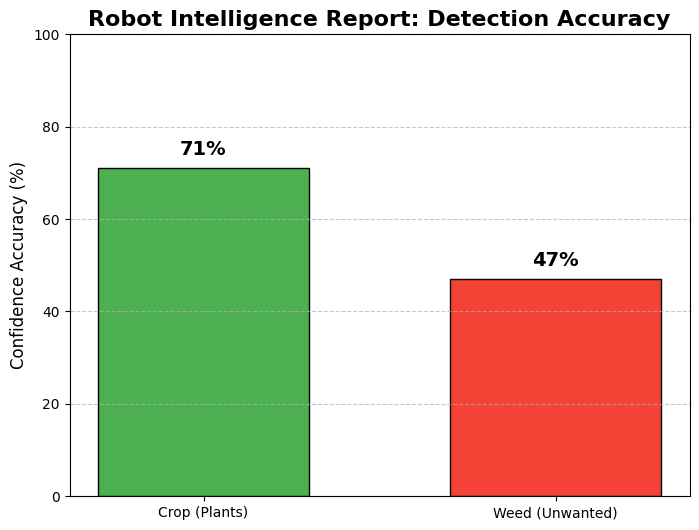

✅ Analysis:
• The Robot is very safe: It recognizes Crops well (71%).
• The Robot is cautious: It finds about half of the Weeds (47%).
• Interpretation: It rarely mistakes a crop, but might miss some small weeds.


In [19]:
import matplotlib.pyplot as plt

# 1. Input the numbers from your training (we took these from your logs)
labels = ['Crop (Plants)', 'Weed (Unwanted)']
accuracy = [71, 47]  # percentages
colors = ['#4CAF50', '#F44336'] # Green for Crop, Red for Weed

# 2. Create a Clean Bar Chart
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, accuracy, color=colors, edgecolor='black', width=0.6)

# 3. Make it look professional
plt.title('Robot Intelligence Report: Detection Accuracy', fontsize=16, fontweight='bold')
plt.ylabel('Confidence Accuracy (%)', fontsize=12)
plt.ylim(0, 100) # Scale from 0 to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Add the specific numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 2, f'{height}%',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# 5. Show it
plt.show()

print("✅ Analysis:")
print("• The Robot is very safe: It recognizes Crops well (71%).")
print("• The Robot is cautious: It finds about half of the Weeds (47%).")
print("• Interpretation: It rarely mistakes a crop, but might miss some small weeds.")


image 1/1 /content/32483_jpg.rf.b5a438c988a8fd2b17991d06a2ba350a.jpg: 384x640 9 weeds, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


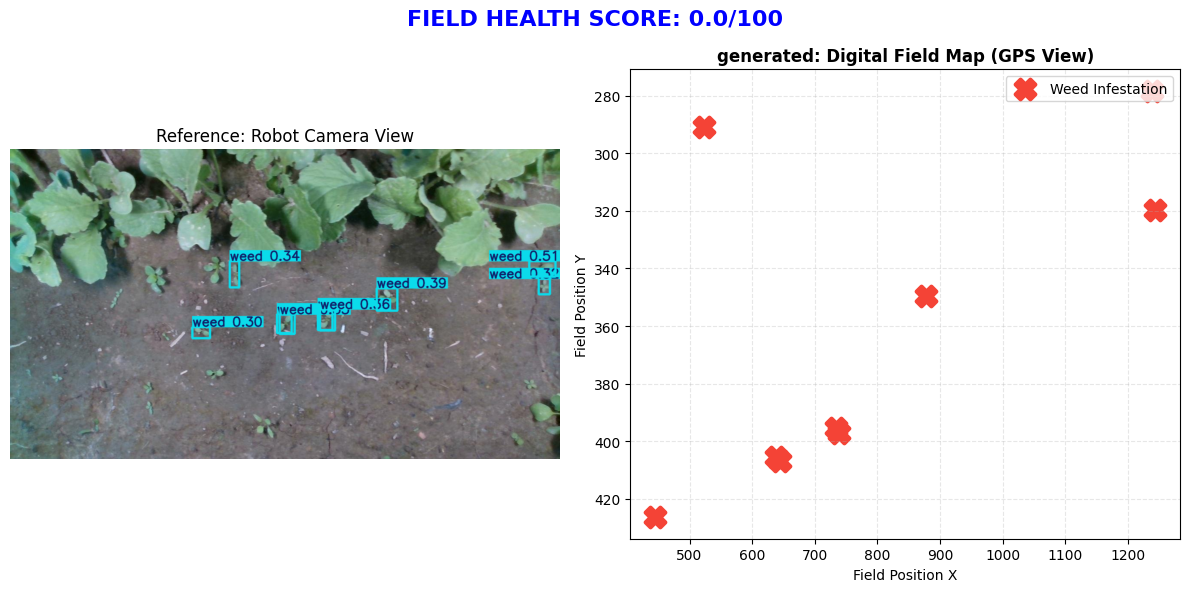

🚜 RECOMMENDATION SYSTEM:
⚠️ CRITICAL ALERT: Heavy infestation. Full field treatment recommended.


In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO

# 1. Load your Model and Image
model = YOLO('/content/runs/detect/train/weights/best.pt')
# We use the same image you uploaded for the heatmap
results = model(img_filename)

# 2. Extract Data (Turn visuals into numbers)
crop_coords = []
weed_coords = []

if len(results) > 0:
    for box in results[0].boxes:
        # Get coordinates (center x, center y)
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        # Get Class Name
        cls_id = int(box.cls[0])
        name = results[0].names[cls_id]

        if name.lower() == 'crop':
            crop_coords.append((center_x, center_y))
        else:
            weed_coords.append((center_x, center_y))

# 3. Generate the "Digital Twin" Map
plt.figure(figsize=(12, 6))

# --- LEFT SIDE: The Robot's Eye (Real Photo) ---
plt.subplot(1, 2, 1)
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.title("Reference: Robot Camera View", fontsize=12)
plt.axis('off')

# --- RIGHT SIDE: The Digital Twin (Data Map) ---
plt.subplot(1, 2, 2)
# Invert Y axis because images start from top-left, graphs from bottom-left
plt.gca().invert_yaxis()

# Plot Crops (Green Circles)
if crop_coords:
    cx, cy = zip(*crop_coords)
    plt.scatter(cx, cy, c='#4CAF50', s=200, label='Healthy Crop', alpha=0.8, edgecolors='black')

# Plot Weeds (Red Xs)
if weed_coords:
    wx, wy = zip(*weed_coords)
    plt.scatter(wx, wy, c='#F44336', s=200, marker='X', label='Weed Infestation', linewidths=3)

# Add grid lines to look like GPS software
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right')
plt.title("generated: Digital Field Map (GPS View)", fontsize=12, fontweight='bold')
plt.xlabel("Field Position X")
plt.ylabel("Field Position Y")

# 4. The "Wow" Factor: Calculated Health Score
total_plants = len(crop_coords) + len(weed_coords)
if total_plants > 0:
    infestation_rate = (len(weed_coords) / total_plants) * 100
    health_score = 100 - infestation_rate
else:
    health_score = 0

plt.suptitle(f"FIELD HEALTH SCORE: {health_score:.1f}/100", fontsize=16, color='blue', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"🚜 RECOMMENDATION SYSTEM:")
if health_score < 50:
    print("⚠️ CRITICAL ALERT: Heavy infestation. Full field treatment recommended.")
elif health_score < 80:
    print("⚠️ WARNING: Spot spraying required. Robot deploying nozzle.")
else:
    print("✅ STATUS: Field is healthy. No action needed.")

In [22]:
from google.colab import files
import os

# 1. Locate the brain file
model_path = '/content/runs/detect/train/weights/best.pt'

if os.path.exists(model_path):
    print(f"✅ Found model at: {model_path}")
    print("⬇️ Starting download to your computer...")

    # 2. Trigger the browser download
    files.download(model_path)

    print("⚠️ IMPORTANT: Save this file safely! This is your entire project.")
else:
    print("❌ Error: Could not find 'best.pt'. Did you verify the training finished?")

✅ Found model at: /content/runs/detect/train/weights/best.pt
⬇️ Starting download to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⚠️ IMPORTANT: Save this file safely! This is your entire project.
